In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from datasets import load_dataset
from tqdm import tqdm
from utils.edit_distance import compute_ngram_distance_damerau_levenshtein
from utils.LCS import find_longest_common_substrings

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# file_path = '/mloscratch/homes/yixuan/PDM/inference/llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79/step=600-consumed=72000_rank0.jsonl'

file_path = '/mloscratch/homes/yixuan/PDM/inference/llama_1.5B_Standard_GBS_120_EPOCH_75/step=300-consumed=36000'

data = load_dataset('json', data_dir=file_path, split='train')

In [7]:
data

Dataset({
    features: ['prefix', 'true_suffix', 'generated_suffix'],
    num_rows: 10000
})

In [ ]:
data

In [ ]:
def describe_array(arr):
    """
    Get descriptive statistics for a numpy array.
    Similar to pandas describe() but for numpy arrays.
    
    Parameters
    ----------
    arr : np.ndarray
        Input array
        
    Returns
    -------
    dict
        Dictionary containing statistics
    """
    stats = {
        'count': len(arr),
        'mean': np.mean(arr),
        'std': np.std(arr),
        'min': np.min(arr),
        '25%': np.percentile(arr, 25),
        '50%': np.median(arr),
        '75%': np.percentile(arr, 75),
        'max': np.max(arr)
    }
    
    # Print in a format similar to pandas describe()
    print("Statistical Description:")
    print(f"count    {stats['count']}")
    print(f"mean     {stats['mean']:.2f}")
    print(f"std      {stats['std']:.2f}")
    print(f"min      {stats['min']}")
    print(f"25%      {stats['25%']:.2f}")
    print(f"50%      {stats['50%']:.2f}")
    print(f"75%      {stats['75%']:.2f}")
    print(f"max      {stats['max']}")

In [4]:
distances, normalized = compute_ngram_distance_damerau_levenshtein(data, N=13)

Converting data to numpy arrays...
Creating sliding windows...
Input shapes: ref_ngrams=(10000, 488, 13), pred_ngrams=(10000, 488, 13)
Warming up Numba JIT...
Computing distances...
Time taken: 2.97 seconds
Output shapes: distances=(10000, 488), normalized=(10000, 488)


In [53]:
distances.shape

(10000, 488)

In [63]:
row_means = distances.mean(axis=1)
describe_array(distances[:9000].mean(axis=1))

Statistical Description:
count    9000
mean     12.10
std      0.90
min      0.05327868852459016
25%      11.83
50%      12.39
75%      12.70
max      12.993852459016393


In [65]:
k = 5
top_k_indices = np.argsort(row_means)[:k]

In [66]:
top_k_indices

array([8413,  546, 8412, 5460, 3078])

Converting data to numpy arrays...
Creating sliding windows...
Input shapes: ref_ngrams=(10000, 496, 5), pred_ngrams=(10000, 496, 5)
Warming up Numba JIT...
Computing distances...
Time taken: 0.32 seconds
Output shapes: distances=(10000, 496), normalized=(10000, 496)


<Axes: >

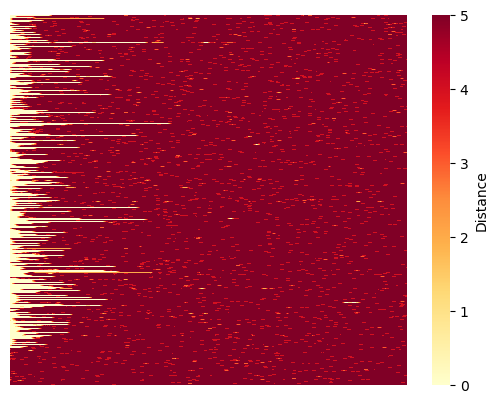

In [69]:
distances, normalized = compute_ngram_distance_damerau_levenshtein(data, N=5)
sns.heatmap(
    distances[:10000], 
    cmap='YlOrRd',  # Use a colormap good for distances
    xticklabels=False,  # Don't show x ticks for large matrices
    yticklabels=False,  # Don't show y ticks for large matrices
    cbar_kws={'label': 'Distance'})

In [21]:
res_statistics = find_longest_common_substrings(data['true_suffix'], data['generated_suffix'])

Warming up Numba JIT...
Processing 10000 sequence pairs in parallel...
Time taken: 1.31 seconds


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
res_statistics.filter(items=['length']).hist(bins=100)

,max_length,start_pos1,end_pos1,start_pos2,end_pos2
0,16,0,16,0,16
1,6,0,6,0,6
2,22,0,22,0,22
3,4,0,4,0,4
4,3,459,462,175,178
...,...,...,...,...,...
9995,4,235,239,177,181
9996,3,85,88,413,416
9997,5,157,162,129,134
9998,3,14,17,133,136


<Axes: xlabel='max_length', ylabel='Count'>

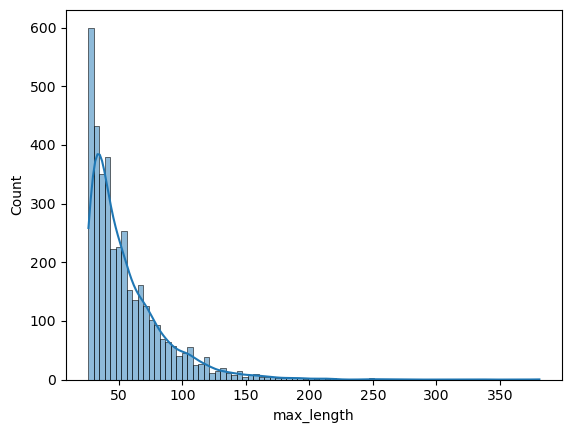

In [52]:
sns.histplot(
    data=res_statistics[res_statistics['max_length'] > 25],
    x='max_length', 
    kde=True, 
    # log_scale=(True, True)
)

In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from tqdm import tqdm

def get_checkpoints(expr_base_dir):
    """
    Get sorted checkpoints from directory
    
    Parameters
    ----------
    expr_base_dir : str
        Base directory containing checkpoints
        
    Returns
    -------
    list
        Sorted list of (step, consumed) tuples
    """
    return sorted([(int(f.name.split('=')[1].split('-')[0]), int(f.name.split('=')[2]))
                  for f in Path(expr_base_dir).glob("step=*")])

def load_inference_data(base_dir, step, consumed):
    """
    Load inference data from a given step
    
    Parameters
    ----------
    base_dir : str
        Base directory path
    step : int
        Training step
    consumed : int
        Number of consumed tokens
        
    Returns
    -------
    Dataset
        HuggingFace dataset containing inference results
    """
    file_path = f"{base_dir}/step={step}-consumed={consumed}"
    return load_dataset('json', data_files=f"{file_path}/rank*.jsonl", split='train')

def calc_avg_lcs_lengths(base_dir, model_ids):
    """
    Calculate average LCS lengths for multiple models
    
    Parameters
    ----------
    base_dir : str
        Base directory containing all model results
    model_ids : list
        List of model identifiers to process
        
    Returns
    -------
    dict
        Dictionary mapping model names to their results
    """
    results = {}
    for model_id in model_ids:
        expr_dir = f"{base_dir}/{model_id}"
        ckpts = get_checkpoints(expr_dir)
        
        steps, avg_lengths = [], []
        for step, consumed in tqdm(ckpts, desc=f"Processing {model_id}"):
            data = load_inference_data(expr_dir, step, consumed)
            lcs_res = find_longest_common_substrings(data['true_suffix'], data['generated_suffix'])
            steps.append(step)
            avg_lengths.append(lcs_res.max_length.mean())
            
        results[model_id] = {'steps': steps, 'avg_lengths': avg_lengths}
    
    return results

In [5]:
def calc_avg_lcs_lengths(base_dir, model_ids):
    """
    Calculate average LCS lengths for multiple models with data split into train/val/test
    
    Parameters
    ----------
    base_dir : str
        Base directory containing all model results
    model_ids : list
        List of model identifiers to process
        
    Returns
    -------
    dict
        Dictionary mapping model names to their results with split information
    """
    results = {}
    for model_id in model_ids:
        expr_dir = f"{base_dir}/{model_id}"
        ckpts = get_checkpoints(expr_dir)
        
        steps, avg_lengths = [], []
        for step, consumed in tqdm(ckpts, desc=f"Processing {model_id}"):
            data = load_inference_data(expr_dir, step, consumed)
            
            # Calculate split indices
            n_total = len(data['true_suffix'])
            n_train = int(n_total * 0.9)
            n_val = int(n_total * 0.05)
            
            # Split data
            splits = {
                'train': {
                    'true_suffix': data['true_suffix'][:n_train],
                    'generated_suffix': data['generated_suffix'][:n_train]
                },
                'val': {
                    'true_suffix': data['true_suffix'][n_train:n_train + n_val],
                    'generated_suffix': data['generated_suffix'][n_train:n_train + n_val]
                },
                'test': {
                    'true_suffix': data['true_suffix'][n_train + n_val:],
                    'generated_suffix': data['generated_suffix'][n_train + n_val:]
                }
            }
            
            # Calculate LCS for each split
            lcs_results = {}
            for split_name, split_data in splits.items():
                lcs_res = find_longest_common_substrings(
                    split_data['true_suffix'], 
                    split_data['generated_suffix']
                )
                lcs_results[split_name] = lcs_res.max_length.mean()
            
            steps.append(step)
            avg_lengths.append(lcs_results)
            
        # Reorganize results by split
        split_results = {
            'train': {'steps': steps, 'avg_lengths': [r['train'] for r in avg_lengths]},
            'val': {'steps': steps, 'avg_lengths': [r['val'] for r in avg_lengths]},
            'test': {'steps': steps, 'avg_lengths': [r['test'] for r in avg_lengths]}
        }
        
        results[model_id] = split_results
    
    return results

In [12]:
def plot_comparison(results, exclude_models=None, exclude_splits=None):
    """
    Plot comparison of models with train/val/test splits
    
    Parameters
    ----------
    results : dict
        Dictionary containing results for each model and split
    exclude_models : list, optional
        List of model IDs to exclude from plotting
    exclude_splits : list, optional
        List of split names to exclude from plotting
    """
    plt.figure(figsize=(12, 6))
    
    # Line styles for different splits
    styles = {
        'train': '-',
        'val': '--',
        'test': ':'
    }
    
    # Filter out excluded splits
    if exclude_splits:
        styles = {k: v for k, v in styles.items() if k not in exclude_splits}
    
    # Filter out excluded models and plot remaining ones
    for model_name, model_results in results.items():
        if exclude_models and model_name in exclude_models:
            continue
            
        # Plot each split with different line style
        for split_name, style in styles.items():
            split_data = model_results[split_name]

            # Convert steps to epochs
            epochs = [step/75 for step in split_data['steps']]

            plt.plot(epochs, split_data['avg_lengths'],
                    linestyle=style,
                    marker='o', 
                    label=f'{model_name} ({split_name})',
                    alpha=0.7)
    
    plt.xlabel('Training Epochs')
    plt.ylabel('Average Memorisation Length')
    plt.title('Average Longest Verbatim Memorisation Length vs Training Steps')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    
    plt.show()

In [8]:
base_dir = "/mloscratch/homes/yixuan/PDM/inference"
model_ids = [
    "llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93",
    "llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83",
    "llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79",
    "llama_1.5B_Standard_GBS_120_EPOCH_75"
]
results = calc_avg_lcs_lengths(base_dir, model_ids)

Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:   0%|          | 0/23 [00:00<?, ?it/s]

Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:   4%|▍         | 1/23 [00:17<06:21, 17.35s/it]

Time taken: 1.36 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.07 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.07 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:   9%|▊         | 2/23 [00:34<05:56, 16.98s/it]

Time taken: 1.38 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  13%|█▎        | 3/23 [00:50<05:34, 16.71s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  17%|█▋        | 4/23 [01:07<05:16, 16.67s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  22%|██▏       | 5/23 [01:23<04:59, 16.66s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  26%|██▌       | 6/23 [01:40<04:43, 16.67s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  30%|███       | 7/23 [01:56<04:24, 16.55s/it]

Time taken: 1.44 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.09 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  35%|███▍      | 8/23 [02:13<04:08, 16.53s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  39%|███▉      | 9/23 [02:29<03:51, 16.55s/it]

Time taken: 1.44 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  43%|████▎     | 10/23 [02:46<03:34, 16.47s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  48%|████▊     | 11/23 [03:03<03:19, 16.61s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  52%|█████▏    | 12/23 [03:19<03:01, 16.51s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  57%|█████▋    | 13/23 [03:35<02:44, 16.50s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  61%|██████    | 14/23 [03:52<02:27, 16.44s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  65%|██████▌   | 15/23 [04:08<02:11, 16.47s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  70%|██████▉   | 16/23 [04:25<01:56, 16.61s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  74%|███████▍  | 17/23 [04:41<01:38, 16.44s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  78%|███████▊  | 18/23 [04:58<01:22, 16.50s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  83%|████████▎ | 19/23 [05:14<01:05, 16.41s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  87%|████████▋ | 20/23 [05:30<00:49, 16.45s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  91%|█████████▏| 21/23 [05:47<00:32, 16.49s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93:  96%|█████████▌| 22/23 [06:04<00:16, 16.48s/it]

Time taken: 1.41 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93: 100%|██████████| 23/23 [06:20<00:00, 16.53s/it]


Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:   0%|          | 0/21 [00:00<?, ?it/s]

Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:   5%|▍         | 1/21 [00:16<05:24, 16.22s/it]

Time taken: 1.35 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.07 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.07 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  10%|▉         | 2/21 [00:32<05:09, 16.27s/it]

Time taken: 1.39 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  14%|█▍        | 3/21 [00:48<04:52, 16.23s/it]

Time taken: 1.41 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  19%|█▉        | 4/21 [01:05<04:39, 16.41s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  24%|██▍       | 5/21 [01:21<04:20, 16.31s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  29%|██▊       | 6/21 [01:37<04:05, 16.36s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  33%|███▎      | 7/21 [01:54<03:47, 16.27s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  38%|███▊      | 8/21 [02:10<03:32, 16.34s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  43%|████▎     | 9/21 [02:26<03:15, 16.32s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  48%|████▊     | 10/21 [02:43<02:59, 16.34s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  52%|█████▏    | 11/21 [02:59<02:43, 16.36s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  57%|█████▋    | 12/21 [03:15<02:26, 16.27s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  62%|██████▏   | 13/21 [03:31<02:09, 16.25s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  67%|██████▋   | 14/21 [03:47<01:53, 16.21s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  71%|███████▏  | 15/21 [04:04<01:38, 16.36s/it]

Time taken: 1.44 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  76%|███████▌  | 16/21 [04:20<01:21, 16.32s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  81%|████████  | 17/21 [04:37<01:05, 16.49s/it]

Time taken: 1.57 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  86%|████████▌ | 18/21 [04:54<00:49, 16.57s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  90%|█████████ | 19/21 [05:12<00:33, 16.86s/it]

Time taken: 1.55 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.09 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83:  95%|█████████▌| 20/21 [05:29<00:17, 17.12s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_10_H_13_GBS_120_EPOCH_83: 100%|██████████| 21/21 [05:46<00:00, 16.50s/it]


Time taken: 1.46 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:   0%|          | 0/19 [00:00<?, ?it/s]

Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:   5%|▌         | 1/19 [00:16<04:57, 16.52s/it]

Time taken: 1.35 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.07 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.07 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  11%|█         | 2/19 [00:32<04:37, 16.32s/it]

Time taken: 1.46 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  16%|█▌        | 3/19 [00:49<04:23, 16.46s/it]

Time taken: 1.67 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  21%|██        | 4/19 [01:05<04:07, 16.49s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...
Time taken: 1.47 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.10 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  26%|██▋       | 5/19 [01:23<03:55, 16.85s/it]

Time taken: 0.09 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  32%|███▏      | 6/19 [01:40<03:39, 16.88s/it]

Time taken: 1.50 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  37%|███▋      | 7/19 [01:56<03:20, 16.67s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  42%|████▏     | 8/19 [02:13<03:03, 16.72s/it]

Time taken: 1.44 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  47%|████▋     | 9/19 [02:29<02:45, 16.57s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...
Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.11 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  53%|█████▎    | 10/19 [02:46<02:30, 16.75s/it]

Time taken: 0.10 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  58%|█████▊    | 11/19 [03:03<02:13, 16.68s/it]

Time taken: 1.55 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  63%|██████▎   | 12/19 [03:20<01:57, 16.73s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  68%|██████▊   | 13/19 [03:36<01:39, 16.54s/it]

Time taken: 1.44 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  74%|███████▎  | 14/19 [03:52<01:22, 16.46s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  79%|███████▉  | 15/19 [04:08<01:05, 16.40s/it]

Time taken: 1.44 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  84%|████████▍ | 16/19 [04:24<00:48, 16.23s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  89%|████████▉ | 17/19 [04:40<00:32, 16.27s/it]

Time taken: 1.47 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79:  95%|█████████▍| 18/19 [04:57<00:16, 16.25s/it]

Time taken: 1.54 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Goldfish_K_21_H_13_GBS_120_EPOCH_79: 100%|██████████| 19/19 [05:13<00:00, 16.52s/it]


Time taken: 1.55 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:   0%|          | 0/19 [00:00<?, ?it/s]

Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:   5%|▌         | 1/19 [00:17<05:15, 17.51s/it]

Time taken: 1.37 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  11%|█         | 2/19 [00:34<04:50, 17.10s/it]

Time taken: 1.39 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  16%|█▌        | 3/19 [00:51<04:34, 17.16s/it]

Time taken: 1.42 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  21%|██        | 4/19 [01:08<04:15, 17.00s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...
Time taken: 1.48 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.09 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  26%|██▋       | 5/19 [01:25<03:57, 16.97s/it]

Time taken: 0.10 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  32%|███▏      | 6/19 [01:41<03:38, 16.81s/it]

Time taken: 1.43 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  37%|███▋      | 7/19 [01:58<03:22, 16.87s/it]

Time taken: 1.50 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...
Time taken: 1.45 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.11 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  42%|████▏     | 8/19 [02:14<03:03, 16.65s/it]

Time taken: 0.11 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  47%|████▋     | 9/19 [02:31<02:46, 16.62s/it]

Time taken: 1.45 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  53%|█████▎    | 10/19 [02:48<02:29, 16.61s/it]

Time taken: 1.58 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  58%|█████▊    | 11/19 [03:04<02:12, 16.58s/it]

Time taken: 1.46 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  63%|██████▎   | 12/19 [03:21<01:57, 16.83s/it]

Time taken: 1.63 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  68%|██████▊   | 13/19 [03:38<01:39, 16.66s/it]

Time taken: 1.49 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  74%|███████▎  | 14/19 [03:54<01:23, 16.61s/it]

Time taken: 1.63 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.09 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  79%|███████▉  | 15/19 [04:10<01:05, 16.49s/it]

Time taken: 1.60 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.09 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  84%|████████▍ | 16/19 [04:28<00:50, 16.67s/it]

Time taken: 1.53 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.09 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  89%|████████▉ | 17/19 [04:44<00:33, 16.60s/it]

Time taken: 1.52 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75:  95%|█████████▍| 18/19 [05:00<00:16, 16.51s/it]

Time taken: 1.54 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.09 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.09 seconds
Warming up Numba JIT...
Processing 9000 sequence pairs in parallel...


Processing llama_1.5B_Standard_GBS_120_EPOCH_75: 100%|██████████| 19/19 [05:17<00:00, 16.70s/it]

Time taken: 1.54 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.09 seconds
Warming up Numba JIT...
Processing 500 sequence pairs in parallel...
Time taken: 0.08 seconds


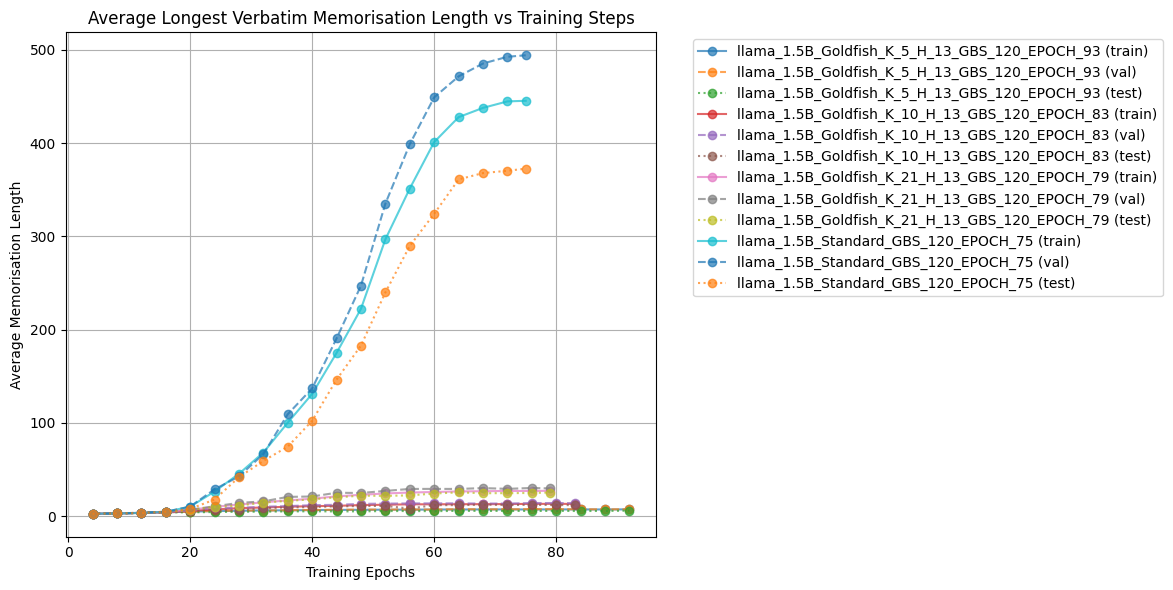

In [11]:
plot_comparison(results)

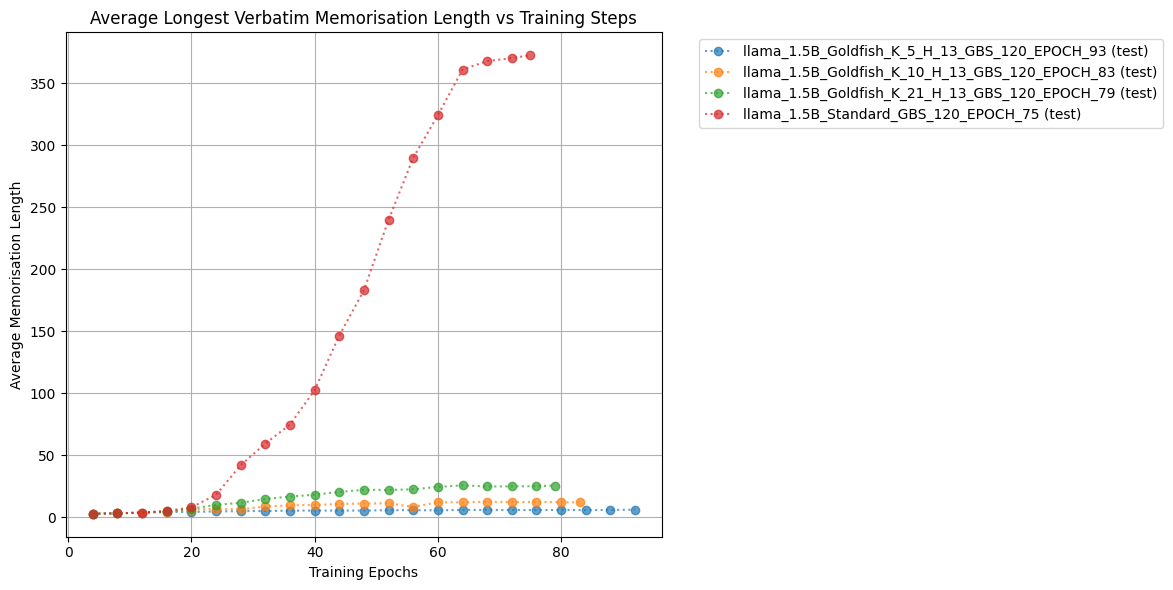

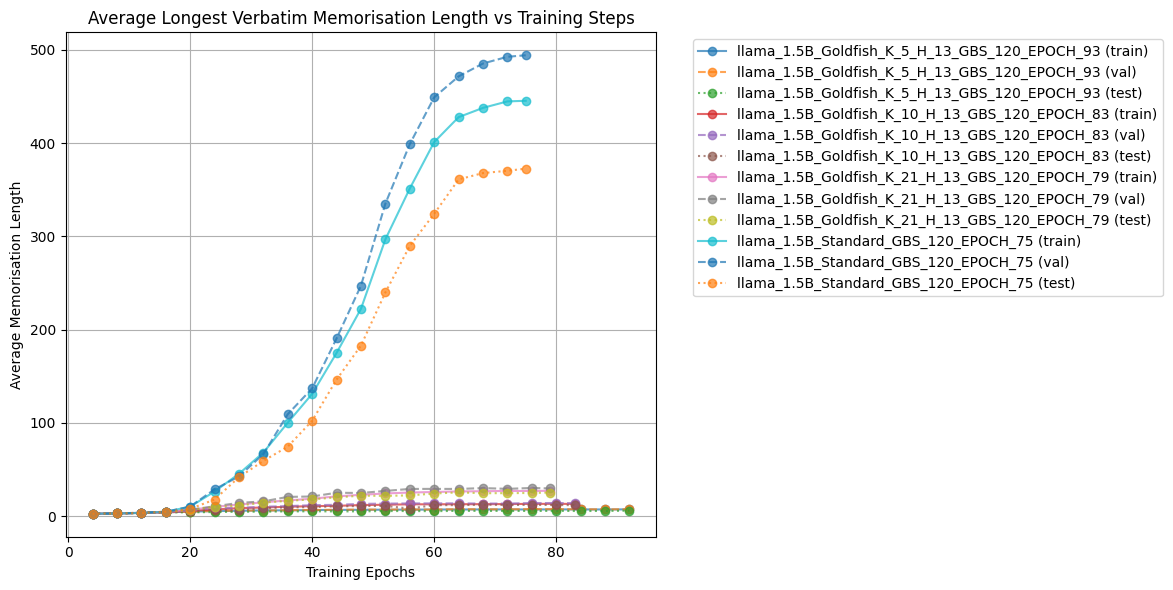

In [ ]:
# Exclude specific models and splits
plot_comparison(results, 
                exclude_splits=['train', 'val'])

In [14]:
results

{'llama_1.5B_Goldfish_K_5_H_13_GBS_120_EPOCH_93': {'train': {'steps': [300,
    600,
    900,
    1200,
    1500,
    1800,
    2100,
    2400,
    2700,
    3000,
    3300,
    3600,
    3900,
    4200,
    4500,
    4800,
    5100,
    5400,
    5700,
    6000,
    6300,
    6600,
    6900],
   'avg_lengths': [2.687333333333333,
    2.9947777777777778,
    3.5816666666666666,
    4.195333333333333,
    4.914555555555555,
    5.520555555555555,
    5.824666666666666,
    6.2155555555555555,
    6.316111111111111,
    6.602555555555556,
    6.744,
    6.886444444444445,
    7.014666666666667,
    7.0472222222222225,
    7.175888888888889,
    7.211555555555556,
    7.283888888888889,
    7.2844444444444445,
    7.25,
    7.315888888888889,
    7.287222222222222,
    7.257666666666666,
    7.3501111111111115]},
  'val': {'steps': [300,
    600,
    900,
    1200,
    1500,
    1800,
    2100,
    2400,
    2700,
    3000,
    3300,
    3600,
    3900,
    4200,
    4500,
    4800,
    5

In [20]:
import pickle  # or import json
import os

# Using pickle (better for complex Python objects)
def save_results(results, save_path):
    """
    Save results dictionary to a file
    
    Parameters
    ----------
    results : dict
        Dictionary containing results
    save_path : str
        Path to save the results (e.g., 'results/data.pkl')
    """
    # Create directory if it doesn't exist
    save_dir = os.path.dirname(save_path)
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        
    with open(save_path, 'wb') as f:
        pickle.dump(results, f)

In [21]:
pwd

'/mloscratch/homes/yixuan/PDM'

In [22]:
save_results(results, './avg_lcs.pkl')

In [23]:
with open('./avg_lcs.pkl', 'rb') as f:
    loaded_results = pickle.load(f)

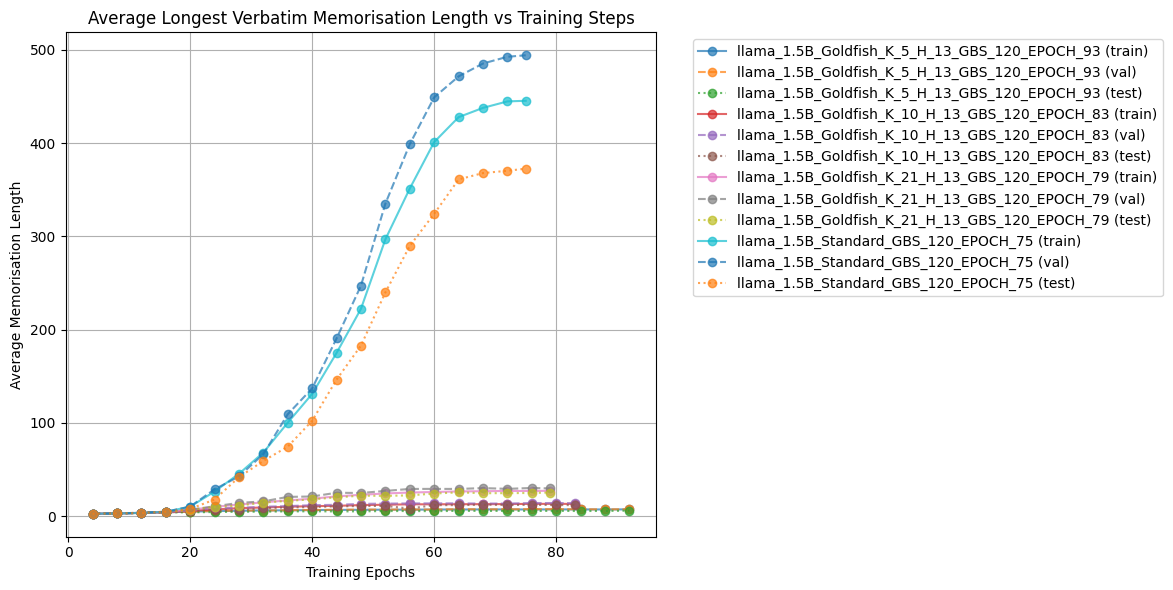

In [24]:
plot_comparison(loaded_results)

In [25]:
def calc_avg_cs_lengths(base_dir, model_ids):
    results = {}
    for model_id in model_ids:
        expr_dir = f"{base_dir}/{model_id}"
        checkpoints = get_checkpoints(expr_dir)
        
        steps, avg_lengths = [], []
        for step, consumed in tqdm(checkpoints, desc=f"Processing {model_id}"):
            data = load_inference_data(expr_dir, step, consumed)
            cs_master = CommonSubstringMatcher(data['true_suffix'], data['generated_suffix'])
            matches = cs_master.get_all_matches()
            
            # Using nanmean for samples with all None matches (empty lists)
            avg_length = np.nanmean([np.mean([match.length if match is not None else 0 
                                         for match in sample]) 
                                for sample in matches])
            
            steps.append(step)
            avg_lengths.append(avg_length)
        
        results[model_id] = {'steps': steps, 'avg_lengths': avg_lengths}
    
    return results